Semblance, Coherence, and other Discontinuity Attributes
==============================

Introduction
-------------

First off, this tutorial is a companion to the short
[article/tutorial](writeup.md) published in The Leading Edge.  If you haven't
yet, have a look at the more detailed introduction there.

Modern 3D seismic interpretation often uses attributes that compare the local
similarity/variance of traces within a seismic volume.  If you're more familiar
with image processing than seismic interpretation, think of them as a class of
3D edge filters adapted for the periodic nature of seismic data (i.e. "wiggles"
instead of more "smooth" data).  These attributes are referred to as
"semblance", "coherence", "similarity", "discontinuity", and many similar
terms, including a number of "trade names" applied to specific implementations
in proprietary software packages.  Here, we'll use the term "discontinuity" to
refer to the general class of attribute, and the others to refer to specific
algorithms.

In practice, you'd typically calculate a discontinuity attribute within a
seismic interpretation package.  In many cases, the algorithms that a
particular software package uses are either considered trade secrets or are not
documented in detail. This leads to discontinuity calculations being treated as
a "black box". Most interpreters use them, but aren't familiar with how they're
calculated. Of course, knowing algorithmic details is not at all necessary to
use discontinuity for interpretation, but it is useful when comparing different
discontinuity attributes or when implementing new methods.

In this tutorial I'll demonstrate algorithms for a few common discontinuity
attributes. I'm going to show simple implementations of a few algorithms with
no regard for practical considerations such as memory use, speed, etc.  The
goal is to show how these types of attributes can be implemented with high-level
"building-blocks". I'm not going to spend much time discussing how, when, or
why one should use one over another.  Which particular algorithm answers a
particular question best is usually specific to the dataset and question at
hand.  Instead, I'll focus on general tradeoffs, such as theoretical
sensitivity to amplitude, noise, etc.  In practice, it's usually best to
compare multiple attributes.  Therefore, the goal of this tutorial is to give you the knowledge to implmenent some of these algorithms and to understand why different discontinuity algorithms give slightly different results.


Our Dataset
-------------

The data we'll be working with is a small subset of the Penobscot 3D seismic dataset [from offshore Nova Scotia](https://opendtect.org/osr/uploads/Main/Penobscot-3D_Loc.jpg), owned by the Nova
Scotia Department of Energy and distributed by dGB Earth Sciences under an
CC-BY-SA license. (Full dataset available at: https://opendtect.org/osr/pmwiki.php/Main/PENOBSCOT3DSABLEISLAND)  

The exact inline/crossline/time ranges of this subset are given in `data/penobscot_subset.hdr`, which is a simple ascii file describing the "raw" data stored in `data/penobscot_subset.bin`.

Stratigraphic Context
----------------------

For context, we're going to be looking at a small region (about 3km by 5km) of the [late Cretaceous to Paleogene section](http://www.callforbids.cnsopb.ns.ca/2013/01/sites/default/files/node/Figure%202.1.jpg) on the Nova Scotian shelf.  The base of our dataset is near the top of the delatic Dawson Canyon formation. The bright, continuous reflectors are within the late Cretaceous Wayndot Chalk.  At the top of these is a major sequence boundary, which incises into the Wayndot Chalk.  The chaotic section at the top of our subset is a distal deltaic section within the Maastrichtian-Paleogene portion of the Banquereau formation, which in this exact area, happens to include a number of mass transport complexes.


Setup
-------

First off, we'll be working in Python.  However, most of these examples focus on using linear algebra and image processing libraries and the concepts should be easily transferrable to other high-level scientific programming languages such as Matlab/Octave or Julia. 

The code in this tutorial depends on Python (2.7 or 3.x) and recent-ish versions of numpy, scipy, and matplotlib.  For 3D visualization, there's an optional dependence on mayavi.

In [2]:
# We'll use non-interactive matplotlib figures embedded in the notebook, for the moment
# Comment this line out or change it to another backend if you'd prefer interactive figures.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.signal

# Local files included with the notebook
# Note that the "data" folder also has an __init__.py file.
# Therefore the "data" folder is treated as a module with functions
# defined in __init__, like "data.load_seismic" and "data.load_horizon"
import data

Let's define a simple plotting fuction to view a crossline and time slice through a 3D numpy array (we'll use this extensively later):

In [3]:
def plot(data, title=''):
    # We'll take slices half-way through the volume (// is integer division)
    j0 = data.shape[1] // 2
    k0 = data.shape[2] // 2
    
    # Setup subplots where one is 3x the height of the other
    # Our data has a fairly narrow time range, so we'll make a cross section 
    # that's 1/3 the height of the time slice
    gs = plt.GridSpec(4, 1)
    fig = plt.figure(figsize=plt.figaspect(1.1))
    ax1 = fig.add_subplot(gs[:-1], anchor='S')
    ax2 = fig.add_subplot(gs[-1], anchor='N')
    
    # Plot the sections
    ax1.imshow(data[:,:,k0].T, cmap='gray')
    ax2.imshow(data[:,j0,:].T, cmap='gray')
    
    # Mark the cross section locations...
    for ax, loc in zip([ax1, ax2], [j0, k0]):
        ax.axhline(loc, color='red')
        ax.set(xticks=[], yticks=[])
    
    ax1.set(title=title)
    plt.show()

Now let's take a look at our input dataset. Once again, this is a small subset of the Penobscot 3D seismic dataset. We'll load it into memory as a 3D numpy array and display a timeslice and inline section using the `plot` function above:

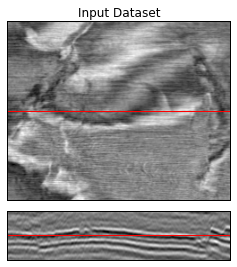

In [4]:
seismic = data.load_seismic()
plot(seismic, 'Input Dataset')

On the right side of the figure, there's a normal fault that tips out towards the top of the time slice.  There are additional features visible in both the time slice and cross section, however, they're difficult to interpret without more detailed investigation.

Speaking of more detailed investigation, you can also explore this dataset in a 3D viewer if you have Mayavi installed. (Click and drag on the secions to move them through the volume.)

In [11]:
from mayavi import mlab

def explore3d(data_cube):
    source = mlab.pipeline.scalar_field(data_cube)
    source.spacing = [1, 1, -1]

    nx, ny, nz = data_cube.shape
    mlab.pipeline.image_plane_widget(source, plane_orientation='x_axes', 
                                     slice_index=nx//2, colormap='gray')
    mlab.pipeline.image_plane_widget(source, plane_orientation='y_axes', 
                                     slice_index=ny//2, colormap='gray')
    mlab.pipeline.image_plane_widget(source, plane_orientation='z_axes', 
                                     slice_index=nz//2, colormap='gray')
    mlab.show()

explore3d(seismic)

One quick comment on execuction speed: I'm deliberately using rather inefficient techniques in most of these examples to keep the code as concise and understandable as possible. Because of that, many of the examples below will take several minutes to run.  If you don't like waiting, consider using a small subset of the data, similar to the subset shown below. (Note: skip the dip-correction example, if you do, as it assumes you're using the full dataset.)

In [16]:
#seismic = data.load_seismic()[10:40, :20, 10:-10]

Now we're ready to explore some various discontinuity attributes. We'll review things in roughly historical order, starting with the earliest approach: Bahorich and Farmer (1995).

Early Algorithms - Cross-correlation
----------------

The earliest discontinuity algorithm was developed by Bahorich and Farmer
(1995) and used the maximum cross correlation value of three traces.  Bahorich
and Farmer coined the term "coherence" for the attribute, based on its
conceptual similarity to pre-stack methods for estimating stacking velocities.
While this exact approach is computationally expensive and not widely used
today, it provides a good starting point to understand later algorithms.

The key here is that the entirety of each trace is correlated with a
"moving-window" subset of two neighboring traces. This has some advantages, such as automatic dip correction, and disadvantages, such as being computationally expensive and sensitive to noise. 

The python function shown below gives a basic example of the algorithm:

In [5]:
def bahorich_coherence(data, zwin):
    ni, nj, nk = data.shape
    out = np.zeros_like(data)
    
    # Pad the input to make indexing simpler. We're not concerned about memory usage.
    # We'll handle the boundaries by "reflecting" the data at the edge.
    padded = np.pad(data, ((0, 1), (0, 1), (zwin//2, zwin//2)), mode='reflect')

    for i, j, k in np.ndindex(ni, nj, nk):
        # Extract the "full" center trace
        center_trace = data[i,j,:]
        
        # Use a "moving window" portion of the adjacent traces
        x_trace = padded[i+1, j, k:k+zwin]
        y_trace = padded[i, j+1, k:k+zwin]

        # Cross correlate. `xcor` & `ycor` will be 1d arrays of length
        # `center_trace.size - x_trace.size + 1`
        xcor = np.correlate(center_trace, x_trace)
        ycor = np.correlate(center_trace, y_trace)
        
        # The result is the maximum normalized cross correlation value
        center_std = center_trace.std()
        px = xcor.max() / (xcor.size * center_std * x_trace.std())
        py = ycor.max() / (ycor.size * center_std * y_trace.std())
        out[i,j,k] = np.sqrt(px * py)

    return out

Now, let's apply this to our test dataset.  Note that we'll need to use a relatively long ``zwin`` window, and that this will take quite some time (5-15 minutes) to compute:

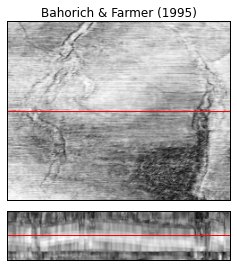

In [6]:
bahorich = bahorich_coherence(seismic, 21)
plot(bahorich, 'Bahorich & Farmer (1995)')

Compared to the "raw" seismic data, this time slice is much easier to interpret. Notice the sinuous features on the left.  While there is likely some minor faulting in addition to the large fault on the right, these sinuous features are easily interpretable as channels in this view, while they were unclear in the timeslice of the "raw" data.

Similar to before, we can view it in 3D if Mayavi is available:

In [7]:
explore3d(bahorich)

If you have time, try varying the ``zwin`` value from 21 to something shorter and longer.  Note that with short windows, the result quickly becomes unclear.  This is because the cross-correlation implictly centers the portion of the trace we're using on its mean, instead of the "true" zero.  For longer traces, the mean is usually zero, but short regions of a trace often hae a non-zero mean.  Due to this, Bahorich and Farmer's algorithm requires large windows and is expensive to compute. 

Generalization to an Arbitrary Number of Traces
-----------------------------------------------
Bahorich and Farmer's (1995) approach was very successful, but it is
sensitive to noise because only three traces are used. Marfurt, et al (1998)
generalized Bahorich and Farmer's cross-correlation approach to an arbitrary
number of input traces, referred to by the authors as "semblance-based
coherence". Marfurt et al's approach also exploits our knowledge that the data
is zero-centered, and avoids centering on the mean of the trace, rather than
the "true" mean of 0. As an example (Note: we'll reuse the ``moving_window``
function in future examples):

In [6]:
def moving_window(data, window, func):
    # `generic_filter` will give the function 1D input. We'll reshape it for convinence
    wrapped = lambda region: func(region.reshape(window))
    
    # Instead of an explicit for loop, we'll use a scipy function to do the same thing
    # The boundaries will be handled by "reflecting" the data, by default
    return scipy.ndimage.generic_filter(data, wrapped, window)

def marfurt_semblance(region):
    # We'll need an ntraces by nsamples array
    region = region.reshape(-1, region.shape[-1])
    ntraces, nsamples = region.shape

    square_of_sums = np.sum(region, axis=0)**2
    sum_of_squares = np.sum(region**2, axis=0)
    return square_of_sums.sum() / sum_of_squares.sum() / ntraces

Now we can apply this to our data (note that it will take a minute or two to compute):

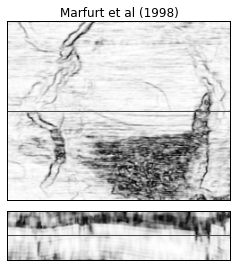

In [22]:
marfurt = moving_window(seismic, (3, 3, 9), marfurt_semblance)
plot(marfurt, 'Marfurt et al (1998)')

Note that both the channels on the left and the fault on the right have become much more clear.  Also, we can now see a discontinuous region (a mass transport complex) in the lower right portion of the timeslice.  We're even starting to get hints of other channels near the upper-left portion of the figure.  

Once again, we can visualize this in 3D, if desired:

In [10]:
explore3d(marfurt)

From an algorithmic perspective, this is similar to Bahorich and Farmer's (1995) approach if the
cross-correlation is only measured at a lag of zero, instead of the maximum
cross correlation. However, Marfurt et al's (1998) method does not require a long
vertical window to produce clear results, leading to faster computational times
and better resolution in the time-direction.  Furthermore, because more
adjacent traces are used, this method is less sensitive to noise, resulting in
a more interpretable result.

Conceptually, Marfurt, et al's (1998) algorithm treats each seismic trace
within the moving window as a separate dimension and measures how close the
resulting point cloud is to a hyper-plane with a slope of 1 in all directions
and intercept of 0.  

It's easiest to visualize for the case of two traces.  For two traces, semblance-based coherence
computes how close the points fall to a line with a slope of 1 and intercept of 0. In the figures below, we'll visualize this by crossplotting two traces. The discretely-sampled amplitude values (blue circles) from each trace will crossplotted on the right-hand portion of the figure.  We'll then measure how close they fall to our line.

Let's start with the case of two identical traces:

<img src="images/semblance_Identical_Traces.png">

When both traces are identical, the values fall perfectly on our line, so the semblance-based coherence is exactly 1.  This is the maximum possible value.

However, if we shift one of the traces down slightly, the samples will have a non-linear pattern:

<img src="images/semblance_Shifted_Traces.png">

Even though the line with a slope of 1 is a good fit to the scatter of points, the points don't fall directly on the line, so the semblance-based coherence is less than 1.

Finally, let's consider what happens when we have two traces with an identical shape, but different amplitudes:

<img src="images/semblance_Different_Amplitude.png">

The samples fall on a perfect line, but the slope of the line is not 1.  Thefore, the semblance-based coherence is below 1.  This is a key theoretical difference between Marfurt, et al's (1998) approach and some other methods.

It is also possible to express this algorithm in terms of a covariance matrix,
where each trace is treated as a separate dimension.  This is mathematically
identical to the example given above, but as we'll see shortly, computing the
covariance matrix allows for other approaches:

In [23]:
def marfurt_semblance2(region):
    region = region.reshape(-1, region.shape[-1])
    ntraces, nsamples = region.shape

    cov = region.dot(region.T)
    return cov.sum() / cov.diagonal().sum() / ntraces

This yields a completely identical result as the implementation shown before. 

Removing Amplitude Sensitivity
------------------------------

One caveat to both Marfurt, et al's (1998) and Bahorich and Farmer's (1995)
method is that they're sensitive to lateral differences in amplitude as well as
differences in phase.  While this is desirable for detecting stratigraphic
features, differences due to lateral changes in amplitude can obscure subtle
structural features.  Gersztenkorn and Marfurt (1999) proposed an
implementation that is sensitive only to lateral changes in phase of the input
waveforms, and not to changes in amplitude: "eigenstructure-based coherence".

Eigenstructure-based coherence (Gersztenkorn and Marfurt, 1999) computes the
covariance matrix of the input region, similar to the previous example.
However, it uses the ratio of the largest eigenvalue of the covariance matrix
to the sum of the eigenvalues:

In [27]:
def gersztenkorn_eigenstructure(region):
    region = region.reshape(-1, region.shape[-1])

    cov = region.dot(region.T)
    vals = np.linalg.eigvalsh(cov)
    return vals.max() / vals.sum()

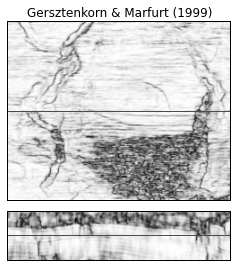

In [25]:
gersztenkorn = moving_window(seismic, (3, 3, 9), gersztenkorn_eigenstructure)
plot(gersztenkorn, 'Gersztenkorn & Marfurt (1999)')

Conceptually, this is similar to treating each seismic trace within the moving
window as a separate dimension and calculating how well the resulting point
cloud is fit by a plane.  To contrast with Marfurt, et al's (1998)
method, for the case of two traces, this measures the scatter about the
best-fit line instead of a line with a slope of 1, as shown below:

Once again, let's start with the case of two identical traces:

<img src="images/eigenstructure_Identical_Traces.png">

When both traces are identical, the values fall perfectly on our line, so the eigenstructure-based coherence is exactly 1, identical to the semblance-based coherence.

When we shift the traces down slightly, we'll change the slop:

<img src="images/eigenstructure_Shifted_Traces.png">

However, even though the slope of best-fit line has changed, the overall scatter around this line is almost identical to a line with a slope of one, so eigenstructure-based and semblance-based coherence estimations give a very similar value.

Finally, let's consider what happens when we have two traces with an identical shape, but different amplitudes:

<img src="images/eigenstructure_Different_Amplitude.png">

The samples fall on a perfect line, but the slope of the line is not 1.  However, unlike semblance-based coherence, eigenstructure-based coherence measures how close the scatter of samples is to the best-fit line. Therefore, Gersztenkorn & Marfurt's (1999) method gives a perfect coherence of 1 in this case.  In other words, eigenstructure-based coherence is only sensitive to phase changes, in theory.  In practice, stratigraphic and structural features are usually expressed through both amplitude and phase changes, so separating the two out is not always advantageous.

Let's look at this side-by-side with Marfurt, et al's (1998) algorithm:

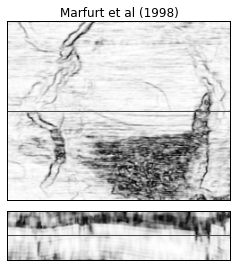

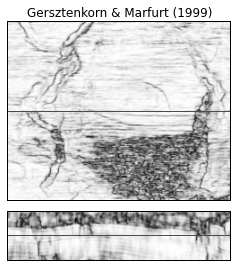

In [26]:
plot(marfurt, 'Marfurt et al (1998)')
plot(gersztenkorn, 'Gersztenkorn & Marfurt (1999)')

Note that Marfurt et al's (1998) method shows more "bold" edges of the channels on the left side of the timeslice.  Because these channels are partly defined by amplitude changes, Gersztenkorn & Marfurt's (1999) approach actually dims the channel edges slightly.  However, it sharpens and more clearly shows fault locations and the internal structure of the mass transport complex at the bottom of the timeslice. This is a good example of the subtle trade-offs between different discontinuity algorithms.

Dip-correction
----------------

A drawback to Marfurt, et al's (1998) and Gersztenkorn and Marfurt's (1999)
approaches is that dipping reflectors will have a uniformly higher
discontinuity (lower coherence/similarity) than non-dipping reflectors. In
other words, these attributes don't distinguish between regional structural dip and
localized discontinuities due to faulting, etc. Therefore, Marfurt
(2006) proposed calculating and correcting for structural dip when performing
discontinuity calculations.   This correction can be applied to any of the
different algorithms discussed so far.  While there are a number of different
methods that can be used to both calculate and correct for structural dip (see
Ch. 2 of Chopra and Marfurt (2007) for a review), dip calculations are beyond
the scope of this tutorial.  Therefore, we'll approximate a dip correction by
flattening on a pre-picked horizon in the interval of interest before applying
a discontinuity calculation (Fig REF).  

In [ ]:
def flatten(data, surface, window):
    surface = scipy.ndimage.gaussian_filter(surface.astype(float), 3)

    ni, nj, nk = data.shape
    ik = np.arange(nk)
    out_ik = np.arange(window) - window // 2

    out = np.zeros((ni, nj, window))
    for i, j in np.ndindex(ni, nj):
        trace = data[i,j,:]
        k = surface[i, j]
        shifted = np.interp(out_ik + k, ik, trace)

        out[i,j,:] = shifted

    return out

def unflatten(data, surface, orig_shape):
    out = np.zeros(orig_shape)
    surface = np.clip(surface, 0, orig_shape[-1] - 1)

    win = data.shape[-1] // 2
    for i, j in np.ndindex(orig_shape[0], orig_shape[1]):
        k = surface[i,j]

        outmin, outmax = max(0, k - win), min(orig_shape[-1], k + win + 1)
        inmin, inmax = outmin - (k - win), k + win + 1 - outmax
        inmax = data.shape[-1] - abs(inmax)

        out[i, j, outmin:outmax] = data[i, j, inmin:inmax]

    return out

def dip_corrected(seismic, window, func):
    surface = data.load_horizon()
    flat = flatten(seismic, surface, seismic.shape[-1])
    sembl = moving_window(flat, window, func)
    return unflatten(sembl, surface, seismic.shape)

Now we can apply it using Gersztenkorn & Marfurt's (1999) algorithm:

In [ ]:
dip_corrected_gersztenkorn = dip_corrected(seismic, (3,3,9), gersztenkorn_eigenstructure)
plot(dip_corrected_gersztenkorn, 'Dip Corrected\nGersztenkorn & Marfurt (1999)')

Or apply it using Marfurt, et al's (1998) algorithm:

In [ ]:
dip_corrected_marfurt = dip_corrected(seismic, (3,3,9), marfurt_semblance)
plot(dip_corrected_marfurt, 'Dip Corrected\nMarfurt, et al (1998)')

The effects of dip correction are less
apparent in our examples due to the relatively low structural dips in the area.
However, dip correction significantly enhances resolution of subtle features in
more structurally complex areas (Marfurt, 2006; Chopra and Marfurt, 2007).

Using the Analytic Trace
------------------------

In addition to dip correction, many authors recommend including the analytic trace in the discontinuity calculation (e.g.
Marfurt, et al, 1999, 2006; Chopra and Marfurt, 2007).  In principle, this
makes the discontinuity estimation less sensitive to zero-crossings in the
original dataset. 

Here's an example of applying this to Gersztenkorn & Marfurt's (1999) algorithm.  We're basically appending the imaginary portion of the analytic trace to the end of the "regular" trace to make each trace twice as long. 

We're also going to be rather inefficent here, and compute the Hilbert transform repeatedly inside the moving window to work around `scipy.ndimage.generic_filter` not supporting complex types. Because of that, this example will take awhile (5-10 minutes) to run:

In [28]:
def complex_eigenstructure(region):
    region = region.reshape(-1, region.shape[-1])

    region = scipy.signal.hilbert(region, axis=-1)
    region = np.hstack([region.real, region.imag])

    cov = region.dot(region.T)
    vals = np.linalg.eigvals(cov)
    return np.abs(vals.max() / vals.sum())

complex_gersztenkorn = moving_window(seismic, (3,3,9), complex_eigenstructure)
plot(complex_gersztenkorn, 'Including Analytic Trace\nGersztenkorn & Marfurt (1999)')

In practice, including the analytic trace information often has a very minor effect, unless an unusually small window is chosen.  For example, let's replot the "regular" version of Gersztenkorn & Marfurt's (1999) algorithm applied to this dataset. The differences between these two are almost unnoticable:

In [ ]:
plot(gersztenkorn, 'Gersztenkorn & Marfurt (1999)')

However, if we use a very short time window, we'll start to see significant differences:

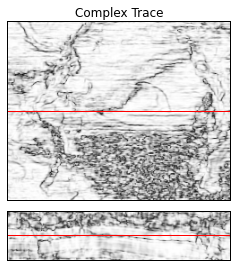

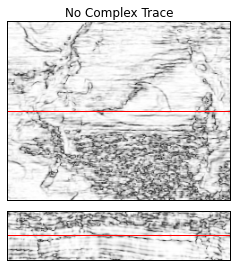

In [31]:
window = (3,3,3)
short_complex = moving_window(seismic, window, complex_eigenstructure)
short_normal = moving_window(seismic, window, gersztenkorn_eigenstructure)

plot(short_complex, 'Complex Trace')
plot(short_normal, 'No Complex Trace')

Notice the "banding" in the bottom cross section of the "No Complex Trace" plot.  Let's plot only the cross sections and make them a bit bigger to show the differences clearly:

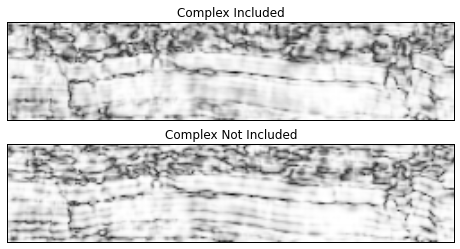

In [32]:
j0 = short_complex.shape[1] // 2

fig, axes = plt.subplots(nrows=2, figsize=plt.figaspect(0.5))
axes[0].imshow(short_complex[:,j0,:].T, cmap='gray')
axes[1].imshow(short_normal[:,j0,:].T, cmap='gray')

axes[0].set(xticks=[], yticks=[], title='Complex Included')
axes[1].set(xticks=[], yticks=[], title='Complex Not Included')
plt.show()

You can see much more pronounced banding parallel to stratigraphy in the bottom image. This is because most covariance-based discontinuity algorithms are sensitive to zero-crossings in the input data.  The imaginary portion of the analytic trace is basically a 90-degree phase shifted version of the original data.  Therefore, it's at a maximum or minimum whenever the real portion crosses zero.  By including the analytic trace, we essentially cancel out the effects of the zero crossings on the discontinuity calculation.  

However, if you're already using a relative long time window, zero-crossings are usually not an issue.  Therefore, it's often better to use a lightly longer window and not include the analytic trace information.

Other Algorithms
------------------

So far, we've mostly focused on algorithms authored by a single, well-regarded group of researchers.  However, there are a number of different discontinuity algorithms that take a very different approach.  

Gradient Structure Tensor


Effect of Window Size and Shape
------------------------------------

One 

In [ ]:
subset = data.load_seismic()[10:30, :20, -10:10]

def vary_xwin(xwin, zwin=9):
    window = xwin, xwin, zwin

Final Thoughts
---------------

Hopefully this tutorial has helped you "peek behind the curtains" at how discontinuity algorithms are implemented.  However, I've only brushed the surface here. There are many more coherence/discontinuity algorithms than the ones discussed above.  Chapter 2 of Chopra and Marfurt (2006) has an excellent review.  Many of the algorithms described there can be implemented using the "building blocks" shown in this tutorial.  If you're feeling ambitious, give it a try!

References
----------

Bahorich, M., and S. Farmer, 1995, 3-D seismic discontinuity for faults and stratigraphic features: The coherence cube: The Leading Edge, *14*, 1053-1058.
doi:10.1190/1.1437077

Chopra, S., and K. J. Marfurt, 2007, Seismic Attributes for Prospect Identification and Reservoir Characterization: *SEG*
doi:10.1190/1.9781560801900

Gersztenkorn, A., and K. J. Marfurt, 1999, Eigenstructure‐based coherence computations as an aid to 3-D structural and stratigraphic mapping: GEOPHYSICS, *64*, 1468-1479.
doi:10.1190/1.1444651

Marfurt, K., V. Sudhaker, A. Gersztenkorn, K. D. Crawford, and S. E. Nissen, 1999, Coherency calculations in the presence of structural dip: GEOPHYSICS, *64*, 104-111.
doi:10.1190/1.1444508

Marfurt, K. J., 2006, Robust estimates of 3D reflector dip and azimuth: GEOPHYSICS, *71*, no. 4, P29-P40.
doi:10.1190/1.2213049

Nova Scotia Department of Energy, 1992, Penobscot 3D Survey. Dataset accessed 19 October, 2015 at
https://opendtect.org/osr/pmwiki.php/Main/PENOBSCOT3DSABLEISLAND

Taner, M. T., And F. Koehler, 1969, Velocity Spectra—Digital Computer Derivation Applications of Velocity Functions: Geophysics, *34*, 859-881.
doi:10.1190/1.1440058
